In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten, tree_structure
import jax_dataclasses as jdc
import chex
from functools import partial
from typing import Callable
import os
from exciting_environments import PMSM_Physical,PMSM
from exciting_environments.pmsm import FastPMSM
import matplotlib.pyplot as plt

In [2]:
# from jax import config
# config.update("jax_enable_x64", True)

In [3]:
random_seed_DQN = np.random.randint(0, 2**31)
random_key_DQN = jax.random.PRNGKey(seed=random_seed_DQN)
random_seed_motor = np.random.randint(0, 2**31)
random_key_motor = jax.random.PRNGKey(seed=random_seed_motor)

random_seed = np.random.randint(0, 2**31)
random_key = jax.random.PRNGKey(seed=random_seed)

In [4]:
new_motor = PMSM_Physical(control_state="torque", deadtime=0,batch_size=1,saturated=True)

In [5]:
new_motor_env = PMSM(new_motor, gamma=0.85,batch_size=1)
#obs, motor_env_state = new_motor_env.reset(random_key_motor)

In [6]:
new_motor_env.env_properties.action_constraints

PMSM.Actions(u_dq=266.6666666666667)

In [7]:
EPISODE_LENGTH = 500
NUM_EPISODES = 2_000
NUM_STATES = 2
x_star = np.zeros((NUM_STATES, NUM_EPISODES, NUM_STATES))
old_motor_env = FastPMSM(x_star,batch_size=2,saturated=True)
#obs, motor_env_state = new_motor_env.reset(random_key_motor)

In [8]:
old_motor_env.reset()

(array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]),
 {},
 False,
 {})

In [9]:
obs, motor_env_state = new_motor_env.reset(random_key_motor)

### Comparison

In [10]:
obs2,_,_,_=old_motor_env.step(np.array([[0.1,0.1],[1,1]]))

In [11]:
obs2

array([[1.96621701e-02, 3.51761868e-04, 3.14159282e-02, 0.00000000e+00,
        0.00000000e+00, 9.94750302e-02, 1.00522223e-01],
       [1.66027412e-01, 4.00577901e-02, 3.14159282e-02, 0.00000000e+00,
        0.00000000e+00, 8.13413567e-01, 9.00527415e-01]])

In [12]:
next_state,obs_next,reward,done=new_motor_env.vmap_step(motor_env_state,jnp.array([[0.1,0.1]]))

In [13]:
obs_next

Array([[ 1.96621700e-02,  3.51761862e-04,  2.06516610e-05,
         9.99506560e-01,  3.14107591e-02, -4.48428829e-01]],      dtype=float64)

### Step comparison

In [14]:
old_motor_env.reset()
obs, motor_env_state = new_motor_env.reset(random_key_motor)
next_state=motor_env_state
i_dqs1=[]
i_dqs2=[]
for _ in range(1000):
    act=[0.1,0.1]
    next_state,obs_next,reward,done=new_motor_env.vmap_step(next_state,jnp.array([act]))
    obs2,_,_,_=old_motor_env.step(np.array([act,act]))
    i_dqs1.append(obs_next[0,0:2])
    i_dqs2.append(obs2[0,0:2])
    if done:
        break

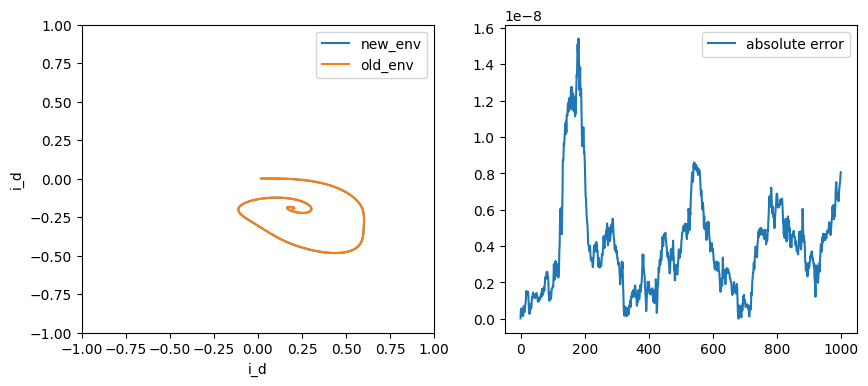

In [15]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].plot(jnp.array(i_dqs1)[:,0],jnp.array(i_dqs1)[:,1],label="new_env")
ax[0].plot(jnp.array(i_dqs2)[:,0],jnp.array(i_dqs2)[:,1],label="old_env")
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].set_xlabel("i_d")
ax[0].set_ylabel("i_d")
ax[0].legend()

ax[1].plot(jnp.linalg.norm(jnp.array(i_dqs1)-jnp.array(i_dqs2),axis=1),label="absolute error")
ax[1].legend()

## Constraints test

In [36]:
ROTATION_MAP = np.ones((2, 2, 2), dtype=np.complex64)
ROTATION_MAP[1, 0, 1] = 0.5 * (1 + np.sqrt(3) * 1j)
ROTATION_MAP[1, 1, 0] = 0.5 * (1 - np.sqrt(3) * 1j)
ROTATION_MAP[0, 1, 0] = 0.5 * (-1 - np.sqrt(3) * 1j)
ROTATION_MAP[0, 1, 1] = -1
ROTATION_MAP[0, 0, 1] = 0.5 * (-1 + np.sqrt(3) * 1j)
def apply_hex_constraint(u_albet):
    """Clip voltages in alpha/beta coordinates into the voltage hexagon"""
    u_albet_c = u_albet[:, 0] + 1j * u_albet[:, 1]
    idx = (np.sin(np.angle(u_albet_c)[..., np.newaxis] - 2 / 3 * np.pi * np.arange(3)) >= 0).astype(int)
    rot_vecs = ROTATION_MAP[idx[:, 0], idx[:, 1], idx[:, 2]]
    # rotate sectors upwards
    np.multiply(u_albet_c, rot_vecs, out=u_albet_c)
    np.clip(u_albet_c.real, -2 / 3, 2 / 3, out=u_albet_c.real)
    np.clip(u_albet_c.imag, 0, 2 / 3 * np.sqrt(3), out=u_albet_c.imag)
    np.multiply(u_albet_c, np.conjugate(rot_vecs), out=u_albet_c)  # rotate back
    return jnp.column_stack([u_albet_c.real, u_albet_c.imag])

In [37]:
apply_hex_constraint(np.array([[1,1]]))

Array([[0.8169873 , 0.89433753]], dtype=float32)

In [75]:
old_motor_env.apply_hex_constraint